In [40]:
import mne
import pywt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.signal import butter, lfilter, argrelextrema
from scipy.fft import fft, fftfreq
from ecgdetectors import Detectors
sns.set_theme()

In [66]:
filenames = [f'data/{name}' for name in ['r01.edf', 'r04.edf', 'r07.edf', 'r08.edf', 'r10.edf']]
fs = 1000
detectors = Detectors(fs)

In [42]:
def read_file(path_to_file: str):
    data = mne.io.read_raw_edf(file)
    raw_data = data.get_data()
    channels = data.ch_names
    return raw_data, channels

In [62]:
def plot_signals(filename, raw_channels, from_index=0, to_index=5000, savefig=False, figsize=(15,5)):
    ts = np.linspace(from_index / fs, to_index / fs, to_index - from_index)
    _, (fqrs, mqrs) = plt.subplots(figsize=figsize, nrows=2)
    fqrs.set_title(f'Fetal QRS {filename}')
    fqrs.set_xlabel('Time [sec]')
    fqrs.set_ylabel('Voltage')
    fqrs.plot(ts, raw_channels[0][from_index: to_index], color='purple')
    
    mqrs.set_title(f'Maternal QRS {filename}')
    mqrs.set_xlabel('Time [sec]')
    mqrs.set_ylabel('Voltage')
    for i in range(1, len(raw_channels)):
        mqrs.plot(ts, raw_channels[i][from_index: to_index], label=channels[i])
        
    plt.legend()
    plt.tight_layout()
    if savefig:
        f = filename.replace('/', '-')
        plt.savefig(f'm&f_qrs-{f}.png')
    plt.show()

# Maternal signal processing

In [44]:
def filter_signal(s, th):
    f_s = fft_filter(s, th)
    return np.real(np.fft.ifft(f_s))

def fft_filter(s, perc):
    fft_signal = np.fft.fft(s)
    fft_abs = np.abs(fft_signal)
    th=perc*(2*fft_abs[0:int(len(s)/2.)]/len(s)/2).max()
    fft_tof=fft_signal.copy()
    fft_tof_abs=np.abs(fft_tof)
    fft_tof_abs=2*fft_tof_abs/len(s)/2
    fft_tof[fft_tof_abs<=th]=0
    return fft_tof

def fft_filter_amp(s, th):
    fft = np.fft.fft(s)
    fft_tof=fft.copy()
    fft_tof_abs=np.abs(fft_tof)
    fft_tof_abs=2*fft_tof_abs/len(s)/2
    fft_tof_abs[fft_tof_abs<=th]=0
    return fft_tof_abs[0:int(len(fft_tof_abs)/2.)]

def ma(sig, ws):
    moving_averages = []
    for i in range(len(sig) - ws + 1):
        window = sig[i : i + ws]
        
        window_average = round(sum(window) / ws, 2)
        moving_averages.append(window_average)
    return moving_averages

In [45]:
def correct_r_peaks(peaks, signal, fs=1000):
    # adjust the estimated maternal R-peak locations by searching the near maximum
    new_peaks = []
    for p in peaks:
        left = max(int(p - fs/10), 0)
        new_p = p
        for i in range(left, int(p + fs/10)):
            if i >= len(signal):
                break
            if signal[i] > signal[new_p]:
                new_p = i
        new_peaks.append(new_p)
    return new_peaks

In [46]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m / sd)

def choose_best_signal(mqrs):
    snrs = [signaltonoise(mqrs[i]) for i in range(len(mqrs))]
    best_signal = snrs.index(max(snrs))
    return mqrs[best_signal]

# Fetal R-peaks estimation

In [90]:
def estimate_fqrs(mqrs, fqrs, figsize=(14,5)):
    th_value = 0.025
    filtered_signal = filter_signal(mqrs, th_value)

    # plt.figure(figsize=(13,3))
    # plt.plot([i / fs for i in range(len(x))], x, color='navy',label='Original Signal')
    # plt.plot([i / fs for i in range(len(x))], example_signal,color='red',label='Filtered signal (Th=%.2f)'%(th_example_value))
    # plt.xlim(0, 4)
    # plt.show()

#     f, (plt1, plt2) = plt.subplots(nrows=2, figsize=figsize)
    predicted = mqrs - filtered_signal   

    idxs = argrelextrema(predicted, np.greater, order=250)[0]
#     plt1.plot([i / fs for i in range(len(fqrs))], fqrs, '--', label='fqrs')
# #     plt1.plot([i / fs for i in range(len(x))], x, color='navy',label='Original Signal')
#     plt1.plot([i / fs for i in range(len(predicted))], predicted, label='Difference (mECG - filtered)')
#     plt1.plot(np.array(idxs) / fs, [predicted[i] for i in idxs], 'ro', label='Detected fetal R-peaks')
#     plt1.set_xlim(0, 4)
#     plt1.set_title('Signals')
#     plt1.set_xlabel('Time [sec]')
#     plt1.set_ylabel('Amplitude [V]')
#     plt1.legend()

#     plt2.plot([i / fs for i in range(len(fqrs))], fqrs)
#     plt2.set_xlabel('Time [sec]')
#     plt2.set_ylabel('Amplitude [V]')
#     plt2.set_xlim(0, 4)
#     plt2.set_title('Original Fetal ECG')
    
#     plt.tight_layout()
    # plt.savefig('signals.png')
#     plt.show()
    return idxs

# Heart rate estimation

In [48]:
def calculate_mean_freq(s):
    distance_between = 0
    for i in range(1, len(s)):
        distance_between += s[i] - s[i-1]
    return distance_between / (len(s) - 1)

def calculate_windowed_heart_rate(s, window_size=100):
    if window_size % 2 == 1:
        window_size -= 1
    freq = []
    for i in range(len(s)):
        left = max(0, int(i - window_size / 2))
        right = min(len(s), int(i + window_size / 2))
        freq.append(calculate_mean_freq(s[left: right]))
    return np.array(freq)

In [49]:
def calculate_mean_bpm(fqrs, fqrs_estimated_peaks):
    # hz = 1 / (calculate_mean_freq(r_peaks) / fs)
    # bpm = hz * 60
    r_peaks = detectors.wqrs_detector(fqrs)
    r_peaks = correct_r_peaks(r_peaks, fqrs)
    print('mean true fetal heart rate:', round(1 / (calculate_mean_freq(r_peaks) / fs) * 60), 'bpm')
    print('mean detected fetal heart rate:', round(1 / (calculate_mean_freq(fqrs_estimated_peaks) / fs) * 60), 'bpm')

In [98]:
def plot_detected_hr_of_record(fqrs, peak_indexes, file):
    r_peaks = detectors.wqrs_detector(fqrs)
    r_peaks = correct_r_peaks(r_peaks, fqrs)
    
    hr = calculate_windowed_heart_rate(peak_indexes)
    ts = np.linspace(0, len(fqrs) / fs, len(hr))
    plt.figure(figsize=(15,3))
    plt.plot(ts, 1 / (hr / fs) * 60, label='predicted HR')
    
    ts = np.linspace(0, len(fqrs) / fs, len(calculate_windowed_heart_rate(r_peaks)))
    plt.plot(ts, 1 / (calculate_windowed_heart_rate(r_peaks) / fs) * 60, label='true HR')

    plt.xlabel('Time [sec]')
    plt.ylim(110, 160)
    plt.ylabel('BPM')
    plt.title('Mean detected fetal heart rate')
    plt.legend()
    f = file.split('/')[1]
    plt.savefig(f'record-{f}.png')
    plt.show()

# Pipeline

Extracting EDF parameters from /Users/alinka/Documents/semester3.1/signals/project/data/r01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
mean true fetal heart rate: 129 bpm
mean detected fetal heart rate: 126 bpm


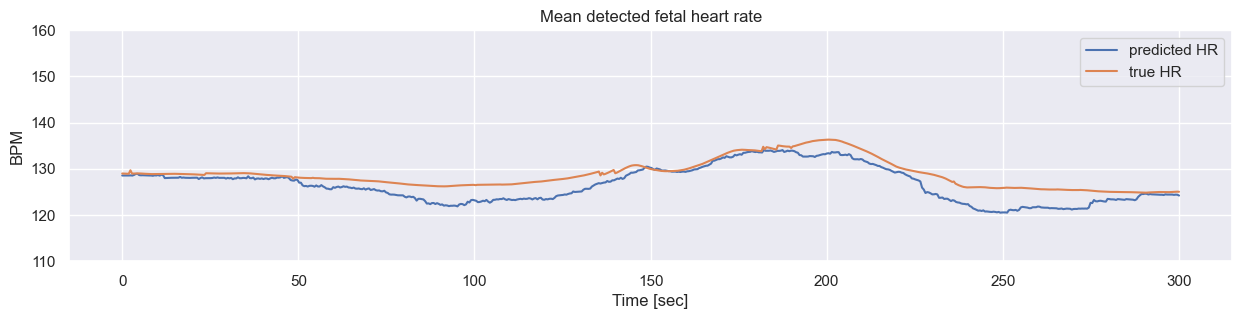

Extracting EDF parameters from /Users/alinka/Documents/semester3.1/signals/project/data/r04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
mean true fetal heart rate: 130 bpm
mean detected fetal heart rate: 127 bpm


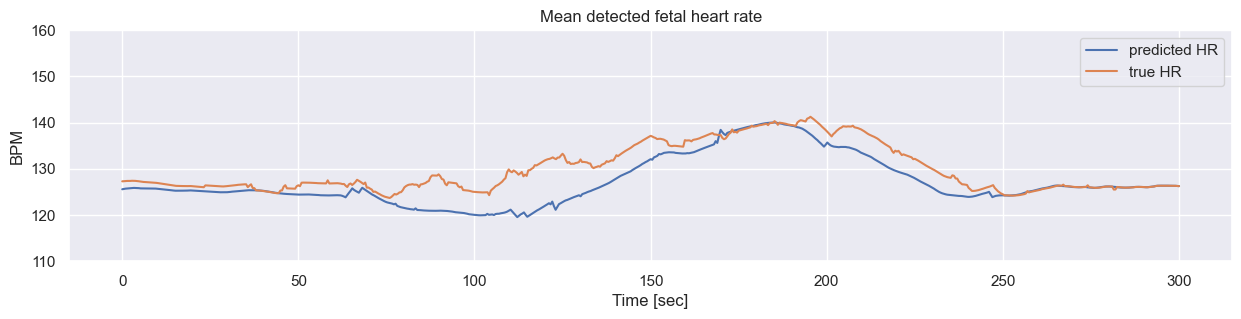

Extracting EDF parameters from /Users/alinka/Documents/semester3.1/signals/project/data/r07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
mean true fetal heart rate: 129 bpm
mean detected fetal heart rate: 117 bpm


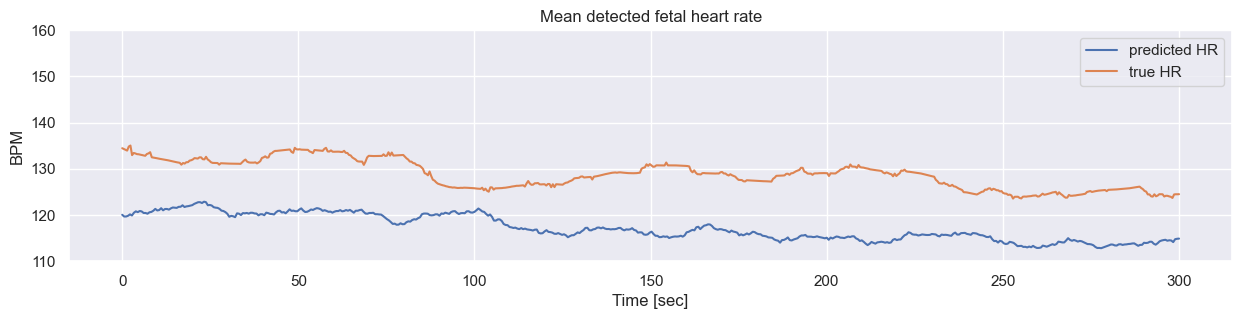

Extracting EDF parameters from /Users/alinka/Documents/semester3.1/signals/project/data/r08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
mean true fetal heart rate: 130 bpm
mean detected fetal heart rate: 128 bpm


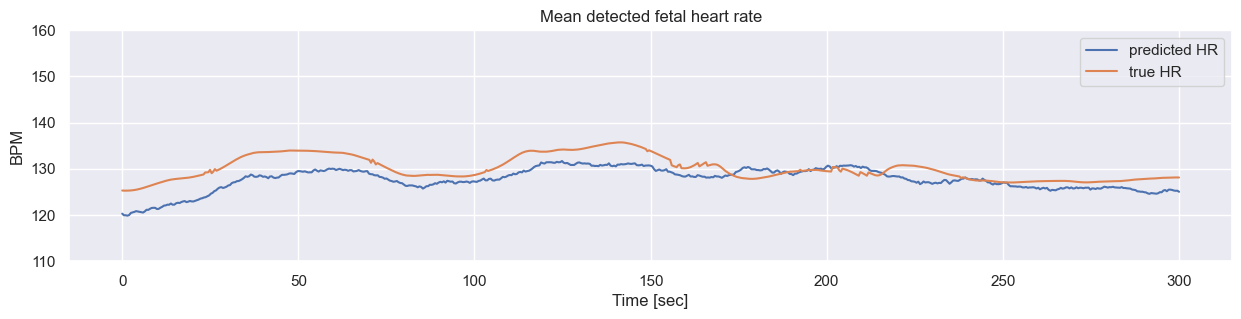

Extracting EDF parameters from /Users/alinka/Documents/semester3.1/signals/project/data/r10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
mean true fetal heart rate: 128 bpm
mean detected fetal heart rate: 128 bpm


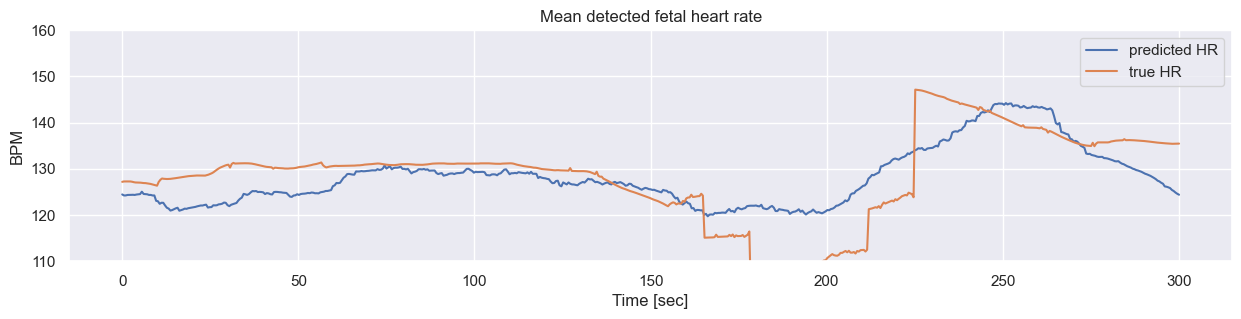

In [99]:
for file in filenames:
    data, channels = read_file(file)
#     plot_signals(file, data)
    snrs = [signaltonoise(data[i]) for i in range(1, 5)]
    channels = []
    important_snr = []
    for i in range(len(snrs)):
        if snrs[i] <= 0:
            continue
        important_snr.append(snrs[i])
        channels.append(estimate_fqrs(data[i], data[0]))
    min_len = min([len(x) for x in channels])
    peaks = np.stack([x[:min_len] for x in channels])
    
    peak_indexes = np.average(peaks, weights=important_snr, axis=0).astype(int)
    calculate_mean_bpm(data[0], peak_indexes)
    plot_detected_hr_of_record(data[0], peak_indexes, file)